<a href="https://colab.research.google.com/github/dagyaom/Python_Practice/blob/main/feature_importance_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- adaboost vs RandomForeset 핵심차이점 3가지.
- 배깅이란? 부스팅이란?
- 특성중요도 계산방법 : perputation importances, feature importance
- gradient boosting 과 xgboost

# 1. 특성공학&전처리&모델학습

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# 타겟설정
target = 'vacc_seas_f'

In [ ]:
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')

# left_index=True, right_index=True join키로 인덱스를 사용함. Key와 index를 혼합해서 합할수도 있다. 
# https://rfriend.tistory.com/259


# 데이터 분리
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

In [ ]:
# # 특성 엔지니어링
# behaviorals = []
# for col in train.columns :
#     if 'behavioral' in col:
#         behaviorals.append(col)
        
# behaviorals 

In [ ]:
# behaviorals = [col for col in train.columns if 'behavioral' in col]
# train['behaviorals'] = train[behaviorals].sum(axis=1)# sum() : 열대로 합계내기.,sum(axis=1) : 한 행 합계내기
# train.head()

In [ ]:
# 특성 엔지니얼이 함수만들기.

def engineer(df) : 
    behaviorals = [col for col in df.columns if 'behavioral' in col]
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    dels = [col for col in df.columns if ('employment' in col or 'h1n1' in col)]
    df.drop(columns=dels, inplace=True)
    
    return df

train = engineer(train)
val = engineer(val)
test = engineer(test)

In [ ]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [ ]:
# 파이프라인 만들기
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

In [ ]:
pipe

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2))])

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# 경고문구 억제 https://www.python2.net/questions-1295170.html, 공식문서https://python.flowdas.com/library/warnings.html

from sklearn.metrics import classification_report

pipe.fit(X_train, y_train)
print(classification_report(y_val, pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4608
           1       0.74      0.70      0.72      3823

    accuracy                           0.75      8431
   macro avg       0.75      0.75      0.75      8431
weighted avg       0.75      0.75      0.75      8431



# 2. 특성중요도 계산법 3가지

## 1) Feature Importances(특성중요도)
- sklearn 트리기반 분류기의 default
- 속도가 빠르다. 
- 각각 특성을 모든 트리에 대해 평균불순도 감소(Mean decrease impurity)를 계산함.
- feature importance는 노드가 분기 할때의 정보 이득 혹은 지니 상수만을 고려하여 중요도를 부여하기 때문에 과적합에 대해 고려하지 못한다.

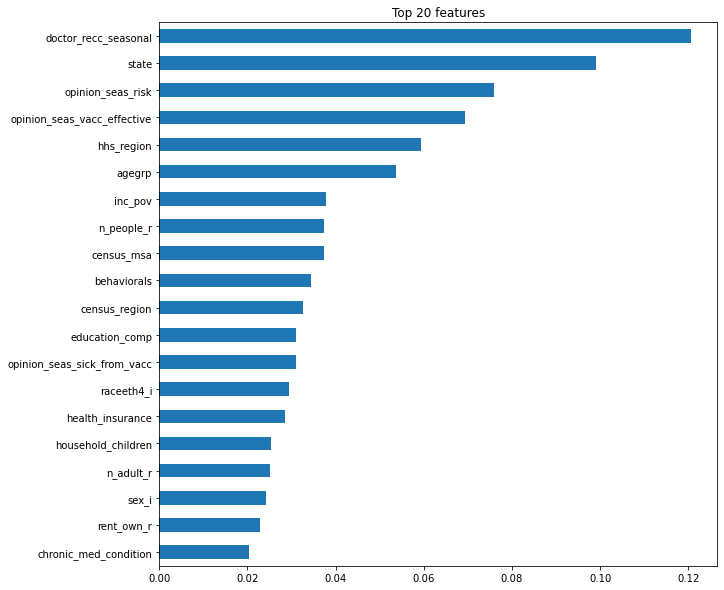

In [ ]:
rf = pipe.named_steps['randomforestclassifier']
rf.feature_importances_
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances

%matplotlib inline  
import matplotlib.pyplot as plt

n=20
plt.figure(figsize = (10,n/2))
plt.title(f'Top {n} features')

importances.sort_values()[-n:].plot.barh();

# %matplotlib inline  : notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 기능 https://korbillgates.tistory.com/85

In [ ]:
len(X_train['state'].value_counts())

51

## 2) Drop-column Importance
- 이론적으로는 좋아보이지만, 매 특성을 drop한 후 다시 fit해야 하기 때문에 매우 느리다.

In [ ]:
column = 'opinion_seas_risk'

# 특성없이 fit
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)
pipe.fit(X_train.drop(columns=column), y_train)
score_without = pipe.score(X_val.drop(columns=column), y_val)
print(f'검증정확도 ({column} 제외 : {score_without})')

# 특성포함 fit
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

pipe.fit(X_train, y_train)
score_with = pipe.score(X_val, y_val)
print(f'검증정확도 ({column}포함) : {score_with}')
    
# 특성 포함 전후 정확도 차이 계산.
print(f'{column}의 Drop-column중요도 : {score_with - score_without}')

검증정확도 (opinion_seas_risk 제외 : 0.733127742853754)
검증정확도 (opinion_seas_risk포함) : 0.7526983750444787
opinion_seas_risk의 Drop-column중요도 : 0.019570632190724635


## 3) Permutation Importance(순열 중요도)
- Mean decrease Accuracy, MDA
- 관심있는 특성에만 무작위로 노이즈를 주고 예측했을 때, 성능평가지표(accuracy, f1, r2 등)가 얼마나 감소하는지를 측정함.
- drop-column 중요도를 계산하기 위해 재학습을 해야했다면, 
- 순열중요도는 검증데이터에서 각 특성을 제거하지 않고 특성값에 무작위로 노이즈를 주어 기존 정보를 제거,
- 특성이 기존에 하던 역할을 하지 못하게 하고 성능을 측정한다. 
- 노이즈를 주는 가장 간단한 방법 : shuffle, permutation. 특성값들을 샘플들 내에서 섞는 것.

### eli5 라이브러리 활용

In [ ]:
from sklearn.pipeline import Pipeline
# Pipeline vs make_pipeline : https://stackoverflow.com/questions/40708077/what-is-the-difference-between-pipeline-and-make-pipeline-in-scikit

# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다.

pipe = Pipeline([('preprocessing', make_pipeline(OrdinalEncoder(),SimpleImputer())),
                ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1))
                ])


In [ ]:
pipe.named_steps

{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                 ('simpleimputer', SimpleImputer())]),
 'rf': RandomForestClassifier(n_jobs=-1, random_state=2)}

In [ ]:
# 모델을 훈련시킨다. 

pipe.fit(X_train, y_train)
print('검증 정확도 : ', pipe.score(X_val, y_val))

검증 정확도 :  0.7526983750444787


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# eli5로 순열중요도를 따져보자. 

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe.named_steps['rf'],  #model
    scoring='accuracy',  #metric
    n_iter=5,   # 다른 random seed를 사용하여 5번 반복
    random_state=2)

# 전처리만 끝내기
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 스코어 계산하기
permuter.fit(X_val_transformed, y_val);


In [ ]:
# 특성별 score 확인
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

n_adult_r                     -0.003511
hhs_region                    -0.003108
census_region                 -0.003084
behavioral_face_mask          -0.003060
sex_i                         -0.002942
state                         -0.002918
behavioral_wash_hands         -0.002657
n_people_r                    -0.002562
behavioral_large_gatherings   -0.002538
behavioral_antiviral_meds     -0.002420
behavioral_avoidance          -0.002159
behavioral_outside_home       -0.002064
behavioral_touch_face         -0.001755
chronic_med_condition         -0.001613
census_msa                    -0.001542
behaviorals                   -0.001471
child_under_6_months          -0.001400
marital                       -0.001328
rent_own_r                    -0.000712
inc_pov                       -0.000474
raceeth4_i                    -0.000213
household_children            -0.000119
education_comp                 0.001234
health_insurance               0.002775
health_worker                  0.003060


In [ ]:
# 시각화

eli5.show_weights(
    permuter,
    top=None,    # top n 지정가능
    feature_names=feature_names
)

# weight(성능 감소량)가 양수의 값을 가지는 변수들은 모델에 큰 영향을 끼친다는 의미이기 때문에 중요한 feature라고 판단할 수 있습니다.
# 반면 성능의 변화가 없거나(0), 음수의 값을 가지는 변수들은 모델에 큰 영향을 끼치지 못하는 
# 즉 중요하지 않은 feature라고 판단할 수 있습니다.

Weight,Feature
0.0714 ± 0.0047,doctor_recc_seasonal
0.0438 ± 0.0034,opinion_seas_vacc_effective
0.0410 ± 0.0032,opinion_seas_risk
0.0077 ± 0.0028,agegrp
0.0048 ± 0.0019,opinion_seas_sick_from_vacc
0.0031 ± 0.0026,health_worker
0.0028 ± 0.0020,health_insurance
0.0012 ± 0.0043,education_comp
-0.0001 ± 0.0025,household_children
-0.0002 ± 0.0028,raceeth4_i


### 직접 계산하기

In [ ]:
# 변경할 특성 선택
feature = 'opinion_seas_risk'
X_val[feature].reset_index()

In [ ]:
# 특성분포 확인
X_val[feature].value_counts()

In [ ]:
# 특성 값 무작위로 섞기.
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.RandomState(seed=10).permutation(X_val_permuted[feature])

# numpy.random.permutation() : 무작위로 섞인 배열을 만든다. https://numpy.org/doc/1.16/reference/generated/numpy.random.RandomState.html
# https://mongxmongx2.tistory.com/11
# 삼성 trio500 키보드 타건감이 별로양

In [ ]:
# 특성값 순서 확인 : 뒤죽박죽
X_val_permuted[feature].reset_index()

In [ ]:
# 카테고리 분포는 바뀌지 않았음 확인
X_val_permuted[feature].value_counts()

In [ ]:
# 순열중요도 확인
score_permuted = pipe.score(X_val_permuted, y_val)

print(f'검증정확도 ({feature}): {score_with}')
print(f'검증정확도 (permuted "{feature}"):{score_permuted}')
print(f'순열중요도: {score_with - score_permuted}')

### feature selection

In [ ]:
# 특성삭제 전
X_train.shape, X_val.shape

((33723, 30), (8431, 30))

In [ ]:
# 정확도 0.001을 기준으로 하여
minimum_importance = 0.001
mask = permuter.feature_importances_>minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [ ]:
permuter.feature_importances_

array([-0.00241964, -0.0021587 , -0.00306014, -0.00265686, -0.00253825,
       -0.00206381, -0.00175543,  0.07142688, -0.00161309, -0.0013996 ,
        0.00277547,  0.00306014,  0.04381449,  0.04103902,  0.00479184,
        0.00773336,  0.00123354, -0.0002135 , -0.00294153, -0.00047444,
       -0.00132843, -0.00071166, -0.00308386, -0.00154193, -0.00351085,
       -0.00011861, -0.00256197, -0.00310758, -0.0029178 , -0.00147076])

In [ ]:
# 특성삭제 후
X_train_selected.shape, X_val_selected.shape

((33723, 8), (8431, 8))

In [ ]:
# 이제 pipeline 다시 정의

pipe1 = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1))
], verbose=1) #verbose : True이면 각 단계를 맞추는 동안 경과된 시간이 완료되는 대로 인쇄됩니다

pipe1.fit(X_train_selected, y_train);

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   1.1s


In [ ]:
print('검증 정확도 :' , pipe1.score(X_val_selected,y_val))

검증 정확도 : 0.7513936662317637


In [ ]:
# 순열 중요도의 평균 감소값과 그 표준편차의 차가 양수인 특징 확인하기

permuter.feature_importances_ - permuter.feature_importances_std_ >0

array([False, False, False, False, False, False, False,  True, False,
       False,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])